In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import math

from torchdiffeq import odeint
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
class ODEFunc(nn.Module):
    def __init__(self, rnn_hidden_dim):
        super().__init__()
        self.nfe = 0   # num forward evaluation

        self.f = nn.Sequential(nn.Linear(rnn_hidden_dim, rnn_hidden_dim),
                          nn.SiLU(),
                          nn.Linear(rnn_hidden_dim, rnn_hidden_dim))

    def reset_nfe(self):
        self.nfe=0

    def forward(self, t, x):
        self.nfe += 1
        return self.f(x)

class RNNODEEncoder(nn.Module):
    def __init__(self, input_dim, output_dim, rnn_hidden_dim):
        super().__init__()
        self.output_dim = output_dim
        if input_dim != 1:
            self.embedding = nn.Linear(1, input_dim)
        self.jump = nn.RNNCell(input_dim, rnn_hidden_dim)
        self.f = ODEFunc(rnn_hidden_dim)
        self.out = nn.Linear(rnn_hidden_dim, 2*output_dim)
        self.rnn_hidden_dim = rnn_hidden_dim
        self.label_embed = nn.Embedding(4, rnn_hidden_dim)

    def forward(self, x, label, span):
        total_nfe = 0

        # x shape should be (batch_size, seq_len, dimension)
        x = self.embedding(x)  #(B, S, E)
        h = self._init_hidden(label)
        Y = []
        for idx in range(x.size(1)-1):
            obs = x[:, idx, :]
            h = self.jump(obs, h)
            t_span = torch.Tensor([span[idx], span[idx+1]])
            h = odeint(self.f, h, t_span, method='rk4')[-1]
            Y.append(self.out(h)[None])
            total_nfe += self.f.nfe
            self.f.reset_nfe()


        # for t in range(x.size(1)):
        #     obs = x[:, t, :]
        #     h = self.jump(obs, h)
        #     h = self.flow(h)
        #     Y.append(self.out(h)[None])

        Y = torch.cat(Y)
        print(f'total nfe: {total_nfe}')
        output = Y[-1]
        z0, qz0_mean, qz0_logvar = self.reparameterization(output)
        return z0, qz0_mean, qz0_logvar

    def _init_hidden(self, label):
        return self.label_embed(label).cuda()    # (B, H)
        # return torch.zeros((x.shape[0], self.rnn_hidden_dim)).cuda()

    def reparameterization(self, z):
        qz0_mean = z[:, :self.output_dim]
        qz0_logvar = z[:, self.output_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(z.device)
        z0 = epsilon * qz0_logvar + qz0_mean
        return z0, qz0_mean, qz0_logvar

class CoeffDecoder(nn.Module):
    def __init__(self, latent_dimension, coeffs_size):
        super().__init__()
        self.latent_dimension = latent_dimension
        self.fc1 = nn.Linear(latent_dimension, latent_dimension)
        self.act1 = nn.SiLU()
        self.fc2 = nn.Linear(latent_dimension, 2*coeffs_size)
        self.act2 = nn.SiLU()
        self.fc3 = nn.Linear(2*coeffs_size, coeffs_size)

    def forward(self, x):
        # input latent vector
        out = self.act1(self.fc1(x))
        out = self.act2(self.fc2(out))
        return self.fc3(out)

def FourierExpansion(n_range, s):
    s_n_range = s * n_range
    basis = [torch.cos(s_n_range), torch.sin(s_n_range)]
    return basis


class FNP_Decoder(nn.Module):
    def __init__(self, args):
        super(FNP_Decoder, self).__init__()
        self.lower_bound, self.upper_bound, self.n_harmonics = args.lower_bound, args.upper_bound, args.n_harmonics
        self.coeffs_size = args.in_features*args.out_features*args.n_harmonics*args.n_eig

        self.coeff_generator = CoeffDecoder(args.latent_dimension + args.num_label, coeffs_size=self.coeffs_size)


    def forward(self, target_x, r):
        # target_x  (B, S, 1), r (B, E)
        assert r.size(-1) == self.coeff_generator.latent_dimension, 'Dimension does not match'
        coeffs = self.coeff_generator(r)  # (B, C)

        # make cos / sin matrix
        cos_x = torch.cos(target_x * 2 * math.pi)  # (B, S, 1)
        sin_x = torch.sin(target_x * 2 * math.pi)  # (B, S, 1)
        for i in range(self.n_harmonics - 1):
            cos_x = torch.cat((cos_x, torch.cos(target_x * 2 * (i+2) * math.pi)), dim=-1)   # (B, S, H)
            sin_x = torch.cat((sin_x, torch.sin(target_x * 2 * (i+2) * math.pi)), dim=-1)   # (B, S, H)

        cos_x = torch.mul(cos_x, coeffs[:, :int(self.coeffs_size/2)].unsqueeze(1))
        sin_x = torch.mul(sin_x, coeffs[:, int(self.coeffs_size/2):].unsqueeze(1))

        cos_x = cos_x.sum(-1) ; sin_x = sin_x.sum(-1)  # (B, S)
        return cos_x + sin_x   # (B, S)

class ConditionalFNP(nn.Module):
    def __init__(self, args):
        super(ConditionalFNP, self).__init__()
        self.dataset_type = args.dataset_type
        self.num_label = args.num_label
        self.latent_dim = args.latent_dimension

        if args.encoder == 'RNNODE':
            self.encoder = RNNODEEncoder(input_dim=args.encoder_embedding_dim, output_dim=args.latent_dimension, rnn_hidden_dim=args.encoder_hidden_dim)
        else:
            raise NotImplementedError

        self.decoder = FNP_Decoder(args)

    def sampling(self, t, x):
        if self.dataset_type == 'sin':
            sample_idxs = torch.sort(torch.LongTensor(np.random.choice(t.size(-1), 150, replace=False)))[0]
            t = t[:, :, sample_idxs]  # (150)
            x = x[:, sample_idxs]
        return t, x


    def forward(self, t, x, label):
        # t (B, 1, 300)  x (B, S, 1)  label(B)
        B = x.size(0)

        t, x = self.sampling(t, x)

        z, qz0_mean, qz0_logvar = self.encoder(x, label, span=t[0][0])
        kl_loss = normal_kl(qz0_mean, qz0_logvar, torch.zeros(z.size()).cuda(), torch.zeros(z.size()).cuda()).sum(-1).mean(0)

        # concat label information
        label_embed = torch.zeros(B, self.num_label).cuda()
        label_embed[range(B), label] = 1

        z = torch.cat((z, label_embed), dim=-1)
        x = x.squeeze(-1)

        decoded_traj = self.decoder(t.permute(0, 2, 1), z)
        mse_loss = nn.MSELoss()(decoded_traj, x)

        return mse_loss, kl_loss

    def predict(self, t, x, label):
        with torch.no_grad():
            B = x.size(0)
            z, qz0_mean, qz0_logvar = self.encoder(x, label, span=t[0][0])

            label_embed = torch.zeros(B, self.num_label).cuda()
            label_embed[range(B), label] = 1

            z = torch.cat((z, label_embed), dim=-1)
            decoded_traj = self.decoder(t.permute(0, 2, 1), z)
        return decoded_traj

    def inference(self, t, label):
        with torch.no_grad():
            z = torch.randn(1, self.latent_dim).cuda()
            label_embed = torch.zeros(1, self.num_label).cuda()
            label_embed[0, label] = 1
            z = torch.cat((z, label_embed), dim=-1)

            decoded_traj = self.decoder(t.permute(0, 2, 1), z)
        return decoded_traj

In [3]:
import pickle

train_data = pickle.load(open('../../input/sin_train_data.pk', 'rb'))
eval_data = pickle.load(open('../../input/sin_eval_data.pk', 'rb'))
test_data = pickle.load(open('../../input/sin_test_data.pk', 'rb'))

In [9]:
import easydict
args = easydict.EasyDict({'dataset_type': 'sin',
                         'dropout': 0.1,
                         'encoder': 'RNNODE',
                         'encoder_embedding_dim': 32,
                         'encoder_hidden_dim': 64,
                         'expfunc': 'fourier',
                         'in_features': 1,
                         'latent_dimension': 32,
                         'lower_bound': 1,
                         'model_type': 'FNP',
                         'num_label': 4,
                         'out_features': 1,
                         'test_model': 'NP',
                         'upper_bound': 6,
                         'n_eig': 2,
                         'n_harmonics': 6})

In [10]:
model = ConditionalFNP(args).cuda()

In [11]:
ckpt = torch.load('./RNNODE_FNP_sin.pt')
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [19]:
np.repeat(train_data['orig_ts'].numpy(), 500, axis=0)

array([[0.        , 0.01003344, 0.02006689, ..., 2.979933  , 2.9899666 ,
        3.        ],
       [0.        , 0.01003344, 0.02006689, ..., 2.979933  , 2.9899666 ,
        3.        ],
       [0.        , 0.01003344, 0.02006689, ..., 2.979933  , 2.9899666 ,
        3.        ],
       ...,
       [0.        , 0.01003344, 0.02006689, ..., 2.979933  , 2.9899666 ,
        3.        ],
       [0.        , 0.01003344, 0.02006689, ..., 2.979933  , 2.9899666 ,
        3.        ],
       [0.        , 0.01003344, 0.02006689, ..., 2.979933  , 2.9899666 ,
        3.        ]], dtype=float32)

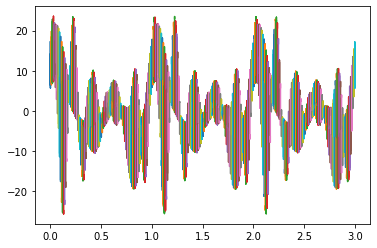

In [22]:
plt.plot(np.repeat(train_data['orig_ts'].numpy(), 2000, axis=0), train_data['train_sin'].squeeze())
plt.show()

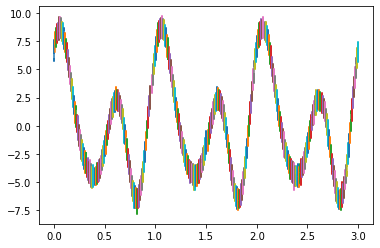

In [24]:
plt.plot(np.repeat(train_data['orig_ts'].numpy(), 500, axis=0), train_data['train_sin'][:500].squeeze())
plt.show()

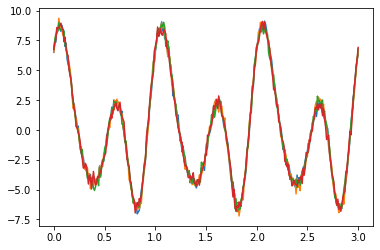

In [28]:
plt.plot(train_data['orig_ts'].squeeze().numpy(), train_data['train_sin'][0].squeeze())
plt.plot(train_data['orig_ts'].squeeze().numpy(), train_data['train_sin'][1].squeeze())
plt.plot(train_data['orig_ts'].squeeze().numpy(), train_data['train_sin'][2].squeeze())
plt.plot(train_data['orig_ts'].squeeze().numpy(), train_data['train_sin'][3].squeeze())
plt.show()